In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
from derivative import dxdt
import pandas as pd


# Frailty Index Model

# $\frac{df}{dt} = a \cdot (1-f)   \cdot (1+bt) - fr(1-st)$


# Mortality Models

# $\mu = f(t)^c$

# $\mu = \mu_0 e^{d\cdot f}$

In [10]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def frailty_index_differential_equation(f, t, a, b, r, s):
    dfdt = a * (1 - f) * (1 + b * t) - f * r * (1 - s * t)
    #dfdt = (1 - f)*(a*f + b) 
    return dfdt

# Time points
t = np.linspace(0, 150, 200)  # 100 time steps from 0 to 10

# Default initial conditions and parameters
f0 = 0.1
a = 0.01
b = 0.09
r = 0.86
s = 0.01

def update_plot(a, b, r, s, initial_condition):
    f_solution = odeint(frailty_index_differential_equation, initial_condition, t, args=(a, b, r, s))

    valor_damage_rate = a*(1+b*t)
    valor_repair_rate = r*(1-s*t)

    c = 1.98
    frailty_index = []
    for i in f_solution:
        frailty_index.append(i[0])
    frailty_index = np.array(frailty_index)
    gompertz_law_differential_equation = frailty_index**c


    file_path = 'Frailty_Phen.csv'

    # Read the CSV file
    data = pd.read_csv(file_path)

    # Access the 'X' and 'Y' columns
    x_values = data['X']  # Assuming 'X' is the header of the column for X coordinates
    y_values = data['Y']  # Assuming 'Y' is the header of the column for Y coordinates

    edad_40_60 = t[40:60]
    data_40_60 = gompertz_law_differential_equation[40:60]
    derivative_process = dxdt(data_40_60, edad_40_60, kind="finite_difference", k=1)
    beta_values_40_60 = derivative_process/data_40_60
    R_values_40_60 = data_40_60/np.e**(beta_values_40_60*edad_40_60)


    edad_60_80 = t[60:80]
    data_60_80 = gompertz_law_differential_equation[60:80]
    derivative_process = dxdt(data_60_80, edad_60_80, kind="finite_difference", k=1)
    beta_values_60_80 = derivative_process/data_60_80
    R_values_60_80 = data_60_80/np.e**(beta_values_60_80*edad_60_80)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    
    ax1.plot(t, f_solution, label='Frailty Index')
    ax1.scatter(x_values, y_values, color = "red")
    ax1.set_xlabel(r'Time')
    ax1.set_ylabel(r'Frailty Index')
    ax1.set_title(r'Frailty Index')
    ax1.legend()
    ax1.grid(True)
    

    ax2.plot(t, valor_damage_rate, color = "blue", label = "Damage Rate")
    ax2.plot(t, valor_repair_rate, color = "red", label = "Repair Rate")
    ax2.set_xlabel(r'Time')
    ax2.set_ylabel(r'Rates values')
    ax2.set_title(r'Damage and Repair rates vs time')
    ax2.legend()
    ax2.grid(True)

    ax3.plot(t, gompertz_law_differential_equation, color = "green")
    ax3.set_xlabel(r'Time')
    ax3.set_ylabel(r'Gompertz Law')
    ax3.set_title(r'Mortality Rate vs time')
    ax3.legend()
    ax3.set_yscale("log")
    ax3.grid(True)
    plt.savefig("Frailty_Rates_Mortality.jpg", dpi = 1000)
    

    ax4.scatter(beta_values_40_60, R_values_40_60, color = "red" ,label = "Ages Window: 40-60")
    ax4.scatter(beta_values_60_80, R_values_60_80, color= "blue", marker='*' ,label = "Ages Window: 60-80")
    ax4.set_title("SM Correlation with Model", fontsize = 16)
    ax4.set_xlabel(r"$\alpha$ parameter", fontsize = 14)
    ax4.set_ylabel(r"$Ln(R_0)$ parameter", fontsize = 14)
    ax4.set_yscale("log")
    ax4.legend()
    ax4.grid(True)

    #plt.savefig("Frailty_Rates_Mortality.jpg", dpi = 1000)

    fig.tight_layout()



# Create sliders for interactive parameter adjustment
slider_a = widgets.FloatSlider(value=a, min=0.0, max=1.0, step=0.001, description='a:')
slider_b = widgets.FloatSlider(value=b, min=0, max=2, step=0.001, description='b:')
slider_r = widgets.FloatSlider(value=r, min=0, max=1, step=0.001, description='r:')
slider_s = widgets.FloatSlider(value=s, min=0, max=0.01, step=0.001, description='s:')
slider_initial_condition = widgets.FloatSlider(value=f0, min=0, max=1, step=0.1, description='Initial Condition:')

# Define the function to be called when sliders are changed
def on_value_change(change):
    a = slider_a.value
    b = slider_b.value
    r = slider_r.value
    s = slider_s.value
    initial_condition = slider_initial_condition.value
    update_plot(a, b, r, s, initial_condition)

# Attach the function to the slider value change event
slider_a.observe(on_value_change, names='value')
slider_b.observe(on_value_change, names='value')
slider_r.observe(on_value_change, names='value')
slider_s.observe(on_value_change, names='value')
slider_initial_condition.observe(on_value_change, names='value')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


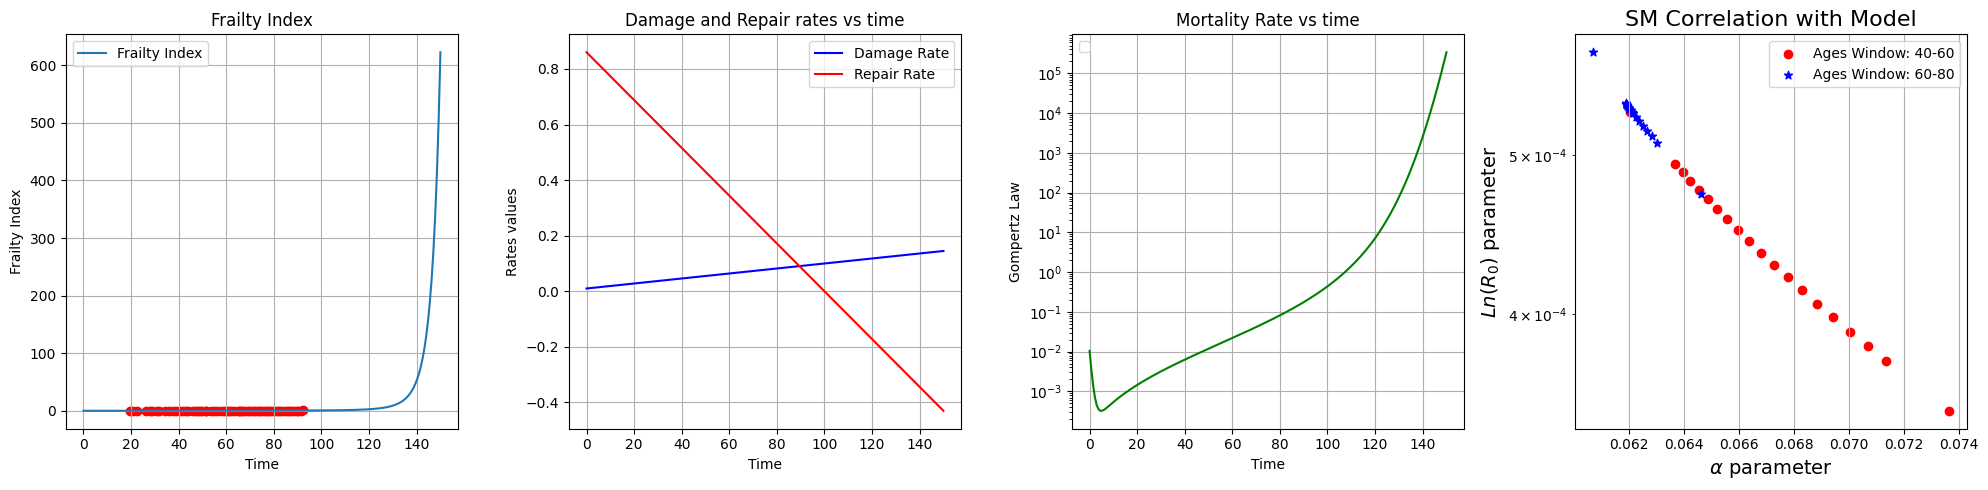

In [11]:
# Display the interactive plot and sliders
display(widgets.VBox([slider_a, slider_b, slider_r, slider_s, slider_initial_condition]))

update_plot(a, b, r, s, f0)  # Display the initial plot

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def frailty_index_differential_equation(f, t, a, b, r, s):
    dfdt = a * (1 - f) * (1 + b * t) - f * r * (1 - s * t)
    #dfdt = (1 - f)*(a*f + b) 
    return dfdt

# Time points
t = np.linspace(0, 100, 100)  # 100 time steps from 0 to 10

# Default initial conditions and parameters
f0 = 0.1
a = 0.01
b = 0.32
r = 0.85
s = 0.01

# Time points
t = np.linspace(0, 100, 100)  # 100 time steps from 0 to 10

# Solving the differential equation
f_solution = odeint(frailty_index_differential_equation, f0, t, args=(a, b, r, s))

# Plot the solution
plt.figure(figsize=(8, 5))
plt.plot(t, f_solution, label='Frailty Index')
plt.xlabel('Time')
plt.ylabel('Frailty Index')
plt.title('Solution of Frailty Index Differential Equation')
plt.legend()
plt.grid(True)


In [ ]:
c = 1.98
frailty_index = []
for i in f_solution:
    frailty_index.append(i[0])
frailty_index = np.array(frailty_index)
gompertz_law_differential_equation = frailty_index**c

plt.figure(figsize=(8, 5))
plt.xlabel(r'Time', fontsize = 14)
plt.ylabel(r'Gompertz Law', fontsize = 14)
plt.title(r'Mortality rate vs time', fontsize = 16)
plt.legend()
plt.scatter(t, gompertz_law_differential_equation)
plt.yscale("log")


In [ ]:
edad_40_60 = t[40:60]
data_40_60 = gompertz_law_differential_equation[40:60]
derivative_process = dxdt(data_40_60, edad_40_60, kind="finite_difference", k=1)
beta_values_40_60 = derivative_process/data_40_60
R_values_40_60 = data_40_60/np.e**(beta_values_40_60*edad_40_60)


edad_60_80 = t[60:80]
data_60_80 = gompertz_law_differential_equation[60:80]
derivative_process = dxdt(data_60_80, edad_60_80, kind="finite_difference", k=1)
beta_values_60_80 = derivative_process/data_60_80
R_values_60_80 = data_60_80/np.e**(beta_values_60_80*edad_60_80)


plt.figure(figsize=(8, 5))
plt.scatter(beta_values_40_60, R_values_40_60, color = "red" ,label = "Ages Window: 40-60")
plt.scatter(beta_values_60_80, R_values_60_80, color= "blue", marker='*' ,label = "Ages Window: 60-80")
plt.title("SM Correlation with Model", fontsize = 16)
plt.xlabel(r"$\alpha$ parameter", fontsize = 14)
plt.ylabel(r"$Ln(R_0)$ parameter", fontsize = 14)
plt.yscale("log")
plt.legend()
plt.savefig("SM_Correlation_Model.jpg", dpi = 1000)

# Variation of damage term and repair term

In [ ]:
t = np.linspace(0, 100, 100)

f0 = 0.1
a = 0.01
b = 0.32
r = 0.85
s = 0.01


valor_damage_rate = a*(1+b*t)
valor_repair_rate = r*(1-s*t)



plt.xlabel('Time')
plt.ylabel('Rates values')
plt.title('Damage and Repair rates vs time')
plt.plot(t, valor_damage_rate, color = "Red", label = "Damage Rate")
plt.plot(t, valor_repair_rate, color = "Green", label = "Repair Rate")
plt.legend()
plt.savefig("Damage_Repair_Rates.jpg", dpi = 1000)

In [ ]:
def frailty_index_differential_equation(f, t, a, b, r, s):
    dfdt = a * (1 - f) * (1 + b * t) - f * r * (1 - s * t)
    #dfdt = (1 - f)*(a*f + b) 
    return dfdt

# Time points
t = np.linspace(0, 100, 100)  # 100 time steps from 0 to 10

# Default initial conditions and parameters
f0 = 0.1
a = 0.01
b = 0.09
r = 0.86
s = 0.01

initial_condition = 0.1

f_solution = odeint(frailty_index_differential_equation, initial_condition, t, args=(a, b, r, s))

valor_damage_rate = a*(1+b*t)
valor_repair_rate = r*(1-s*t)

c = 1.98
frailty_index = []
for i in f_solution:
    frailty_index.append(i[0])
frailty_index = np.array(frailty_index)
gompertz_law_differential_equation = frailty_index**c


file_path = 'Frailty_Phen.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Access the 'X' and 'Y' columns
x_values = data['X']  # Assuming 'X' is the header of the column for X coordinates
y_values = data['Y']  # Assuming 'Y' is the header of the column for Y coordinates

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(t, f_solution, label='Frailty Index')
ax1.scatter(x_values, y_values, color = "red", label = "Observational data")
ax1.set_xlabel(r'Time')
ax1.set_ylabel(r'Frailty Index')
ax1.set_title(r'Frailty Index')
ax1.legend()
ax1.grid(True)


ax2.plot(t, valor_damage_rate, color = "blue", label = "Damage Rate")
ax2.plot(t, valor_repair_rate, color = "red", label = "Repair Rate")
ax2.set_xlabel(r'Time')
ax2.set_ylabel(r'Rates values')
ax2.set_title(r'Damage and Repair rates vs time')
ax2.legend()
ax2.grid(True)

ax3.plot(t, gompertz_law_differential_equation, color = "green", label = "Mortality Curve")
ax3.set_xlabel(r'Time')
ax3.set_ylabel(r'Gompertz Law')
ax3.set_title(r'Mortality Rate vs time')
ax3.legend()
ax3.set_yscale("log")
ax3.grid(True)
plt.savefig("Frailty_Rates_Mortality.jpg", dpi = 1000)